# Simple ChatBot

In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph,START , END

## Reducers
from typing import Annotated
from langgraph.graph.message import add_messages

Annotated tells the framework how to treat that field — for example, Annotated[list, add_messages] marks the message field as the chat history so LangGraph can automatically manage and append messages during conversation flow.

In [2]:
class State(TypedDict):
    message: Annotated[list,add_messages]

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ['api_key']=os.getenv('api_key')
os.environ['LangGraph_api_key'] = os.getenv('LangGraph_api_key')

In [4]:
from langchain_groq import ChatGroq

llm = ChatGroq(model_name="openai/gpt-oss-20b", api_key=os.environ['api_key'])

In [5]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("groq:openai/gpt-oss-20b", api_key=os.environ['api_key'])

In [6]:
llm.invoke("Hello, how are you?")

AIMessage(content="Hello! I'm doing great—thanks for asking. How can I help you today?", additional_kwargs={'reasoning_content': 'User greeting. Should respond politely.'}, response_metadata={'token_usage': {'completion_tokens': 34, 'prompt_tokens': 77, 'total_tokens': 111, 'completion_time': 0.033419172, 'prompt_time': 0.003645541, 'queue_time': 0.046983279, 'total_time': 0.037064713}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_e99e93f2ac', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None}, id='run--c7ccec15-fa98-4483-8622-2de10382bbf0-0', usage_metadata={'input_tokens': 77, 'output_tokens': 34, 'total_tokens': 111})

## Creating NODES

In [7]:
def chatbot(state:State):
    return{"message": llm.invoke(state['message'])}

In [ ]:
graph = StateGraph(State)

## NODE
graph.add_node("chatbot",chatbot)

## Adding Engdes
graph.add_edge(START,"chatbot")
graph.add_edge("chatbot",END)

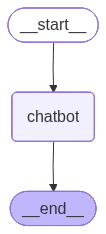

In [9]:
graph_builder=graph.compile()
from IPython.display import display,Image

## Visualizing the Graph
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [10]:
graph_builder.invoke({"message": "Who won the Cricket World Cup in 2019?"})

{'message': [HumanMessage(content='Who won the Cricket World Cup in 2019?', additional_kwargs={}, response_metadata={}, id='78262059-9d8e-462a-bdfa-3fd38383b138'),
  AIMessage(content='The 2019 ICC Cricket World Cup was won by **England**. They beat New\u202fZealand in the final, which ended in a tie and was decided by a Super Over, giving England their first World Cup title.', additional_kwargs={'reasoning_content': 'User asks: "Who won the Cricket World Cup in 2019?" The answer: England won the 2019 ICC Cricket World Cup, beating New Zealand in a final that was decided by a Super Over, after a tie. So answer: England. Probably mention the match.'}, response_metadata={'token_usage': {'completion_tokens': 113, 'prompt_tokens': 82, 'total_tokens': 195, 'completion_time': 0.131690412, 'prompt_time': 0.005554842, 'queue_time': 0.050357218, 'total_time': 0.137245254}, 'model_name': 'openai/gpt-oss-20b', 'system_fingerprint': 'fp_3d587a02fb', 'service_tier': 'on_demand', 'finish_reason': 's

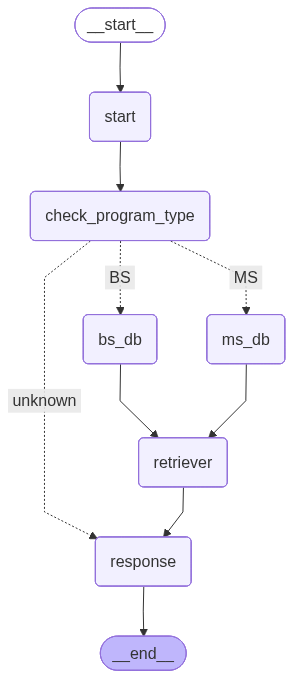

In [11]:
# simple_langgraph.py

from langgraph.graph import StateGraph, END

# Define the state
class GraphState(dict):
    """Shared state between nodes"""

# Define nodes
def start(state: GraphState):
    print("Start: Received query")
    # Example query added in state
    state["query"] = "Outline of BS Computer Science"
    return state

def check_program_type(state: GraphState):
    print("Checking whether query is for BS or MS program...")
    q = state.get("query", "").lower()

    if "bs" in q:
        state["program_type"] = "BS"
        return "bs_db"
    elif "ms" in q:
        state["program_type"] = "MS"
        return "ms_db"
    else:
        state["program_type"] = "unknown"
        return "response"

def bs_program_db(state: GraphState):
    print("Accessing BS Program Database...")
    state["data"] = "BS Program Outline fetched."
    # 👇 Place your Retriever call here later
    return "retriever"

def ms_program_db(state: GraphState):
    print("Accessing MS Program Database...")
    state["data"] = "MS Program Outline fetched."
    # 👇 Place your Retriever call here later
    return "retriever"

def retriever(state: GraphState):
    # 👇 Replace this dummy function with your actual retriever logic
    print("Retriever: fetching and ranking relevant information...")
    state["retrieved_docs"] = ["Doc1", "Doc2"]
    return "response"

def response(state: GraphState):
    print("Generating response...")
    result = f"Program Type: {state.get('program_type')}\nData: {state.get('data')}\nRetrieved: {state.get('retrieved_docs')}"
    print(result)
    return state

# Build graph
graph = StateGraph(GraphState)
graph.add_node("start", start)
graph.add_node("check_program_type", check_program_type)
graph.add_node("bs_db", bs_program_db)
graph.add_node("ms_db", ms_program_db)
graph.add_node("retriever", retriever)
graph.add_node("response", response)

# Set entry and edges
graph.set_entry_point("start")
graph.add_edge("start", "check_program_type")
graph.add_conditional_edges(
    "check_program_type",
    lambda s: s.get("program_type"),
    {
        "BS": "bs_db",
        "MS": "ms_db",
        "unknown": "response"
    }
)
graph.add_edge("bs_db", "retriever")
graph.add_edge("ms_db", "retriever")
graph.add_edge("retriever", "response")
graph.add_edge("response", END)

# Compile and run
graph.compile()
